In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

In [4]:
from pathlib import Path

import matplotlib.pyplot as plt
import stamina
from PIL import Image

images_folder = Path("../data/jpeg")
folders = list(images_folder.glob("*"))
folders[0], folders[0].is_dir()

(PosixPath('../data/jpeg/45'), True)

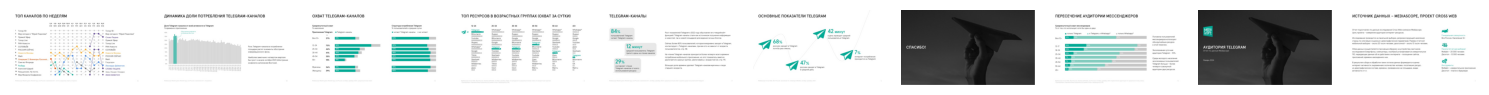

In [5]:
# [pin]
files = list(folders[0].iterdir())[:10]
fig, axes = plt.subplots(1, len(files), figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    img = Image.open(files[i])
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [6]:
import torch
from qdrant_client import QdrantClient
from qdrant_client.http import models
from tqdm import tqdm

In [7]:
qdrant_client = QdrantClient(
    url="http://ml.n19:6333",
    api_key="",
)

/home/worker/workspace/media-digital-rag/.conda/lib/python3.11/site-packages/qdrant_client/qdrant_remote.py:130: UserWarning: Api key is used with an insecure connection.
  warnings.warn("Api key is used with an insecure connection.")


In [8]:
from colpali_engine.models import ColPali, ColPaliProcessor

# Initialize ColPali model and processor
model_name = "vidore/colpali-v1.2"  # Use the latest version available
colpali_model = ColPali.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="cuda:0",  # Use "cuda:0" for GPU, "cpu" for CPU, or "mps" for Apple Silicon
)
colpali_processor = ColPaliProcessor.from_pretrained("vidore/colpali-v1.2")

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
collection_name = "pdfs-2"

qdrant_client.create_collection(
    collection_name=collection_name,
    on_disk_payload=True,  # store the payload on disk
    vectors_config=models.VectorParams(
        size=128,
        distance=models.Distance.COSINE,
        on_disk=True,  # move original vectors to disk
        multivector_config=models.MultiVectorConfig(
            comparator=models.MultiVectorComparator.MAX_SIM
        ),
        quantization_config=models.BinaryQuantization(
            binary=models.BinaryQuantizationConfig(
                always_ram=True  # keep only quantized vectors in RAM
            ),
        ),
    ),
)

True

In [10]:
@stamina.retry(
    on=Exception, attempts=3
)  # retry mechanism if an exception occurs during the operation
def upsert_to_qdrant(batch):
    try:
        qdrant_client.upsert(
            collection_name=collection_name,
            points=points,
            wait=False,
        )
    except Exception as e:
        print(f"Error during upsert: {e}")
        return False
    return True

In [11]:
batch_size = 8  # Adjust based on your GPU memory constraints

# Use tqdm to create a progress bar
dataset = list(Path("../data/jpeg/").rglob("*jpg"))

with tqdm(total=len(dataset), desc="Indexing Progress") as pbar:
    for i in range(0, len(dataset), batch_size):
        batch = dataset[i : i + batch_size]

        # The images are already PIL Image objects, so we can use them directly
        images = [Image.open(el) for el in batch]

        # Process and encode images
        with torch.no_grad():
            batch_images = colpali_processor.process_images(images).to(
                colpali_model.device
            )
            image_embeddings = colpali_model(**batch_images)

        # Prepare points for Qdrant
        points = []
        for j, embedding in enumerate(image_embeddings):
            # Convert the embedding to a list of vectors
            multivector = embedding.cpu().float().numpy().tolist()
            points.append(
                models.PointStruct(
                    id=i + j,  # we just use the index as the ID
                    vector=multivector,  # This is now a list of vectors
                    payload={
                        "source": "internet archive"
                    },  # can also add other metadata/data
                )
            )

        # Upload points to Qdrant
        try:
            upsert_to_qdrant(points)
        except Exception as e:
            print(f"Error during upsert: {e}")
            continue

        # Update the progress bar
        pbar.update(batch_size)

print("Indexing complete!")

Indexing Progress: 4664it [11:30,  6.75it/s]                          

Indexing complete!


In [12]:
qdrant_client.update_collection(
    collection_name=collection_name,
    optimizer_config=models.OptimizersConfigDiff(indexing_threshold=10),
)

True

In [13]:
query_text = "Как за 10 лет изменилось количество телепрограмм, привлекающих более 4-х млн. зрителей в Великобритании?"
# query_text = "Как развивается геймдев в Москве?"
with torch.no_grad():
    batch_query = colpali_processor.process_queries([query_text]).to(
        colpali_model.device
    )
    query_embedding = colpali_model(**batch_query)
query_embedding

tensor([[[ 0.1641, -0.0327,  0.0981,  ..., -0.0200, -0.0752, -0.0129],
         [ 0.0178, -0.0840,  0.0352,  ...,  0.0535, -0.0312,  0.0562],
         [ 0.0564,  0.0889, -0.0255,  ..., -0.0077, -0.0674,  0.0513],
         ...,
         [-0.0322, -0.0148,  0.0215,  ...,  0.0593, -0.0238, -0.1162],
         [-0.0300, -0.0087,  0.0064,  ...,  0.0825, -0.0052, -0.1455],
         [ 0.0127,  0.0454,  0.0762,  ...,  0.0693,  0.0079, -0.1108]]],
       device='cuda:0', dtype=torch.bfloat16)

In [14]:
multivector_query = query_embedding[0].cpu().float().numpy().tolist()

In [15]:
import time

start_time = time.time()
search_result = qdrant_client.query_points(
    collection_name=collection_name,
    query=multivector_query,
    limit=10,
    timeout=100,
    search_params=models.SearchParams(
        quantization=models.QuantizationSearchParams(
            ignore=False,
            rescore=True,
            oversampling=2.0,
        )
    ),
)
end_time = time.time()
# Search in Qdrant
search_result.points

elapsed_time = end_time - start_time
print(f"Search completed in {elapsed_time:.4f} seconds")

Search completed in 1.0591 seconds


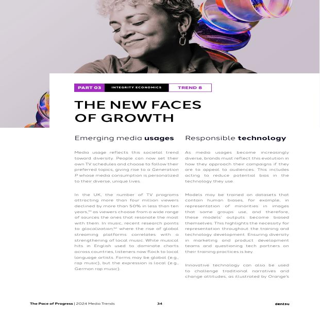

In [16]:
idx = search_result.points[0].id
Image.open(dataset[idx]).resize((320, 320))

In [23]:
from utils import request_with_image

response = request_with_image(
    query_text=query_text,
    image_path=dataset[idx],
    system_prompt="You are required to give a clear answer to the question posed",
)

In [24]:
# [pin]
response.choices[0].message.content

'По статистике за 10 лет количество телепрограмм, привлекающих более 4-х млн. зрителей, сократилось на 50%.'